In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import mne # reads edf format
import glob
import random
import re
import wfdb # waveform database library wfdb.rdann reads annotation of physiology annotated data in ECG, EEG etc


### Objective:
#### Signal Extraction

Codes extensively modified from work by [Mashahiro Goton](https://www.kaggle.com/code/hemangjindal/chb-mit-eeg-dataset-my-notebook#CHB-MIT-eeg-dataset-seizure-detection-demo). \[Online] [Accesssed on 20 October 2024].

EDfToNpy class contains:
1. read_efd - read edf formatted seizure file. Identify parameters for creating numpy arrays. Ensure correct channels and calculate samples of seizure and non seizure files.
2. extract_edf - create appropriate numpy arrays using arguments obtained from read_edf method. Copy data and labels to numpy array, then save to file as npy format.
3. show_EEG - display EEG


---

#### Signal Extraction

The code presented in this notebook is extensively modified from work by [Mashahiro Goton](https://www.kaggle.com/code/hemangjindal/chb-mit-eeg-dataset-my-notebook#CHB-MIT-eeg-dataset-seizure-detection-demo).
**[Online] Accessed on 20 October 2024.**

#### Overview of the `EdfToNpy` Class

The `EdfToNpy` class provides functionalities for processing EEG data from EDF files, specifically from the CHB-MIT dataset. It includes the following methods:

1. **`read_edf`**:
   - Reads EDF-formatted seizure files.
   - Identifies parameters for creating NumPy arrays, ensuring correct channel mapping.
   - Calculates samples for both seizure and non-seizure files.

2. **`extract_edf`**:
   - Creates NumPy arrays using the parameters obtained from the `read_edf` method.
   - Copies EEG data and corresponding labels to NumPy arrays, then saves these as `.npy` files for efficient storage and processing.

3. **`show_EEG`**:
   - Displays EEG signals graphically, providing a visual representation of the data across channels.

---
This script is designed to perform custom segmentation of EEG data from the CHB-MIT public dataset, which contains hours of continuous EEG recordings. The segmentation process extracts data into manageable 10-second windows, enabling efficient processing and analysis. The ultimate goal is to convert the raw EDF-format data into CSV files, reducing the file size (originally **42.6 GB of data from the Children’s Hospital of Boston-MIT Scalp EEG Dataset (Shoeb,2009) [Online] Accessed on 20 October 2024.**) and facilitating easier handling during analysis.

---

### Key Steps:
1. **Library Imports**:
   - Import the `mne` library for handling EDF files and `pandas` for data manipulation and export.

2. **Reading EDF Files**:
   - Utilise `mne.io.read_raw_edf` to read each EDF file within the dataset.
   - Extract EEG signal data using the `get_data` method.

3. **Data Conversion**:
   - Transform the EEG signal data into a NumPy array using `numpy.vstack`.
   - The vertical stack operation reshapes data into the format: _samples × features_, making it compatible for analysis.

4. **Export to CSV**:
   - Save the processed data into CSV files using `pandas.DataFrame.to_csv`. CSV format is smaller in size and allows easier processing across multiple platforms.

---

### Additional Information:
This notebook acts as a preprocessing tool that simplifies the complex structure of continuous EEG data into structured samples. It enables researchers or engineers to:
- Efficiently analyse smaller, well-defined EEG segments.
- Perform further steps like machine learning model training or statistical analysis.

In [2]:
# Define the raw data source directory for the CHB-MIT dataset.
# The dataset contains 23 patients. Each patient's data is stored in a folder:
# - Each folder is named with an integer identifier ranging from 0 to 24.
# - Note: 22 patients have a single folder, and 1 patient (chb21) has two folders.

path = r'data\raw_data\chb-mit-scalp-eeg-database-1.0.0'

# Retrieve and sort the list of data folders based on their assigned numeri
data_folders = sorted(glob.glob(os.path.join(path, '*[0-9]')))


def file_id(folder):
    """
    Extracts the last two characters of each folder's name, corresponding to its numeric identifier.

    Parameters:
        folder (list): List of folder paths.

    Returns:
        list: List of folder identifiers as strings.
    """
    return [ name[-2:] for name in [file.rsplit('\\',2)[-1] for file in folder]]

# Display the retrieved folder identifiers.

print("Case ID: ")
print(file_id(data_folders))

Case ID: 
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']


In [5]:
# The seizure marking is included in the name of the EDF file, not in a separate file.
# Split the data folders into training and testing sets.

train_test_ratio = 0.8
random.seed(80)

# Randomly sample folders for the training set, then sort them.
train_folders = sorted(random.sample(data_folders, round(len(data_folders) * train_test_ratio)))

# Assign the remaining folders to the testing set and sort them.
test_folders = sorted([ file for file in data_folders if file not in train_folders])

# Display the IDs and counts of training and testing folders.
print(f"train_folders' IDs: {file_id(train_folders)}, contains {len(train_folders)} files")
print(f"test_folders' IDs: {file_id(test_folders)}, contains {len(test_folders)} files")


train_folders' IDs: ['01', '02', '04', '07', '08', '09', '10', '12', '13', '14', '15', '16', '17', '18', '19', '20', '22', '23', '24'], contains 19 files
test_folders' IDs: ['03', '05', '06', '11', '21'], contains 5 files


In [6]:
# Retrieve all EDF files for training and testing sets.

# Collect all EDF files from the training folders.
train_files = [ file for folder in train_folders for file in glob.glob(folder+'/*.edf')]

# Collect all EDF files from the testing folders.
test_files = [ file for folder in test_folders for file in glob.glob(folder+'/*.edf')]

# Display the counts of training and testing files.
print(f"Train_files contains {len(train_files)} files")
print(f"Test_files contains {len(test_files)} files")

# Display a random example of a file from the training set.
print(f"Random example from train_files: {random.choice(train_files)}")


Train_files contains 523 files
Test_files contains 163 files
Random example from train_files: data\raw_data\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_16.edf


#### Sampling a file at random

In [5]:
# This code demonstrates reading neurophysiological data from an EDF file using the MNE library.

# Load the first EDF file from the training set without preloading data into memory.
sample_edf = mne.io.read_raw_edf(train_files[0], preload=False)
sample_edf.info

Extracting EDF parameters from C:\Users\mspla\Documents\repos\py_basic_310_Au24\seizurePy3.9\data\raw_data\chb-mit-scalp-eeg-database-1.0.0\chb01\chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\mspla\AppData\Local\Temp\ipykernel_5836\3700619184.py:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  sample_edf = mne.io.read_raw_edf(train_files[0], preload=False)


<Info | 8 non-empty values
 bads: []
 ch_names: FP1-F7, F7-T7, T7-P7, P7-O1, FP1-F3, F3-C3, C3-P3, P3-O1, ...
 chs: 23 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2076-11-06 11:42:54 UTC
 nchan: 23
 projs: []
 sfreq: 256.0 Hz
 subject_info: 1 item (dict)
>

In [6]:
# Identify the montage used for surface electrodes.
# The montage refers to the naming convention used to identify each surface scalp electrode.

# Display a description of the EDF file, including details about the electrode placement and montage.
sample_edf.describe()

<RawEDF | chb01_01.edf, 23 x 921600 (3600.0 s), ~27 kB, data not loaded>
ch  name      type  unit        min         Q1     median         Q3        max
 0  FP1-F7    EEG   µV      -807.03     -24.03      -1.37      19.73    1037.95
 1  F7-T7     EEG   µV      -726.54     -17.00       0.20      17.00     549.55
 2  T7-P7     EEG   µV      -544.47     -13.48       0.20      14.26     588.62
 3  P7-O1     EEG   µV      -449.52     -10.74       0.59      11.53     206.11
 4  FP1-F3    EEG   µV      -882.44     -26.37      -0.98      22.86     792.19
 5  F3-C3     EEG   µV      -431.94     -14.65       0.20      15.04     402.25
 6  C3-P3     EEG   µV      -417.09     -10.35       0.20      10.74     536.65
 7  P3-O1     EEG   µV      -201.03     -13.48       0.20      14.26     229.94
 8  FP2-F4    EEG   µV      -563.61     -24.03      -0.98      20.51     700.76
 9  F4-C4     EEG   µV      -262.76     -13.48       0.20      13.48     235.41
10  C4-P4     EEG   µV      -284.64     -10.35 

#### Surface electrodes

In [9]:
channel_labels = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3','P3-O1',
                  'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2',
                  'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8-1']



---

### The International 10-20 Electrode Placement System

The **10-20 International System** is a globally standardised method for positioning scalp electrodes in EEG recordings. It ensures uniformity and reproducibility in electrode placement, allowing consistent measurement of brain signal amplitudes across studies.

#### Electrode Configuration:
- **Older Systems**: Utilise 18 pairs of channels for brain signal detection.
- **Modern Systems**: May include 23, 24, or even 26 pairs of channels, depending on the complexity and requirements of the analysis.

#### Project Implementation:
For this project, we are using **23 channels** to extract and analyse EEG signals effectively.

#### EEG Montage:
- EEG files represent a montage of amplitudes detected across multiple channels.
- Each channel records the electrical potential difference between two specific scalp electrodes.
- The montage is arranged systematically:
  - **From left to right** across the scalp.
  - **From the front (frontal region) to the back (occipital region)**.

#### Electrode Labels:
The following labels correspond to the channels used in this project:

```python
['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1',
 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2',
 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8-1']
```

These labels follow the 10-20 International System, ensuring optimal coverage of the scalp for reliable signal acquisition. The systematic arrangement enables analysis of neural activity across hemispheres and regions of interest.

---

#### Signal Extraction

Codes extensively modified from work by [Mashahiro Goton](https://www.kaggle.com/code/hemangjindal/chb-mit-eeg-dataset-my-notebook#CHB-MIT-eeg-dataset-seizure-detection-demo). \[Online] [Accesssed on 20 October 2024].

EDfToNpy class contains:
1. read_efd - read edf formatted seizure file. Identify parameters for creating numpy arrays. Ensure correct channels and calculate samples of seizure and non seizure files.
2. extract_edf - create appropriate numpy arrays using arguments obtained from read_edf method. Copy data and labels to numpy array, then save to file as npy format.
3. show_EEG - display EEG


---

#### Signal Extraction

The code presented in this notebook is extensively modified from work by [Mashahiro Goton](https://www.kaggle.com/code/hemangjindal/chb-mit-eeg-dataset-my-notebook#CHB-MIT-eeg-dataset-seizure-detection-demo).
**[Online] Accessed on 20 October 2024.**

#### Overview of the `EdfToNpy` Class

The `EdfToNpy` class provides functionalities for processing EEG data from EDF files, specifically from the CHB-MIT dataset. It includes the following methods:

1. **`read_edf`**:
   - Reads EDF-formatted seizure files.
   - Identifies parameters for creating NumPy arrays, ensuring correct channel mapping.
   - Calculates samples for both seizure and non-seizure files.

2. **`extract_edf`**:
   - Creates NumPy arrays using the parameters obtained from the `read_edf` method.
   - Copies EEG data and corresponding labels to NumPy arrays, then saves these as `.npy` files for efficient storage and processing.

3. **`show_EEG`**:
   - Displays EEG signals graphically, providing a visual representation of the data across channels.

---

In [ ]:
class EdfToNpy:
    # Constants
    WINDOW_TIME = 10  # segment size in second
    STEP_TIME = 5     # Step size in second
    SEIZURE_PROPORTION = 0.01    # proportion of seizure
    TO_MICROVOLTS = 1e6
    channel_labels = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1',
                      'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2',
                      'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8-1']

    def __init__(self, folder, save_to):
        self.save_to = save_to
        self.folder = folder

    # Read edf formatted file
    def read_edf(self):
        """
        Processes EDF files to extract EEG data and calculate seizure proportions.

        Returns:
        count (int): The total number of EEG windows processed.
        num_channels (int): The total number of EEG channels.
        window_size (int): The size of the window in data points.
        """
        count = 0  # initialize the count variable
        window_size = 0  # initialize the window_size variable

        for file in self.folder:
            edf_data = mne.io.read_raw_edf(file, preload=False)
            edf_labels = edf_data.ch_names

            # Validate channel labels

            if sum([any([0 if re.match(c, l) is None else 1 for l in edf_labels]) for c in EdfToNpy.channel_labels]) == len(EdfToNpy.channel_labels):
                sampling_freq = int(1 / (edf_data.times[1] - edf_data.times[0]))
                window_size = sampling_freq * EdfToNpy.WINDOW_TIME
                window_stride = sampling_freq * EdfToNpy.STEP_TIME

                # Seizure annotation handling

                has_seizure = np.zeros((edf_data.n_times,))
                if os.path.exists(file + '.seizures'):
                    has_annotation = wfdb.rdann(file, 'seizures')
                    for idx in range(int(has_annotation.sample.size / 2)):
                        has_seizure[has_annotation.sample[idx * 2]:has_annotation.sample[idx * 2 + 1]] = 1

                # Calculate seizure proportions in sliding windows

                has_seizure_idx = np.array([has_seizure[idx * window_stride:idx * window_stride + window_size].sum() / window_size for idx in range((edf_data.n_times - window_size) // window_stride)])

                # Calculate non-seizure and seizure window counts

                noseizure_n_size = round(EdfToNpy.SEIZURE_PROPORTION * np.where(has_seizure_idx == 0)[0].size)
                seizure_n_size = np.where(has_seizure_idx > 0)[0].size
                count = count + noseizure_n_size + seizure_n_size  # increment count to tally total samples

            edf_data.close()

        return count, len(EdfToNpy.channel_labels), window_size

    # Segment data into 10-second window and save data to numpy data file. Also save seizure annotation to numpy label file.
    def extract_edf(self, n_samples, n_channel_labels, window_size):
        """
        Extracts EEG signals and labels from EDF files, processes them, and saves the data as NumPy arrays.

        Parameters:
        n_samples (int): The total number of samples to process.
        n_channel_labels (int): The number of EEG channels.
        window_size (int): The size of the window in data points.

        Saves:
        _signals.npy: Processed EEG signals.
        _labels.npy: Corresponding seizure and non-seizure labels.
        """
        signals_np = np.zeros((n_samples, n_channel_labels, window_size), dtype=np.float32)
        labels_np = np.zeros(n_samples, dtype=np.int32)
        count = 0  # initialize the count variable

        for number, file in enumerate(self.folder):
            edf_data = mne.io.read_raw_edf(file, preload=False)

            # Check for matching channel labels

            n_label_match = sum([any([0 if re.match(ch, ch_name) is None else 1 for ch_name in edf_data.ch_names]) for ch in EdfToNpy.channel_labels])
            if n_label_match == len(EdfToNpy.channel_labels):
                # Rename channels to standardised labels
                dict_ch_name = {sorted([ch_name for ch_name in edf_data.ch_names if re.match(ch, ch_name) is not None])[0]: ch for ch in EdfToNpy.channel_labels}
                edf_data.rename_channels(dict_ch_name)

                has_seizure = np.zeros((edf_data.n_times,))
                signals_ = edf_data.get_data(picks=EdfToNpy.channel_labels) * EdfToNpy.TO_MICROVOLTS

                # Bandpass filter was not applied in this earlier version,
                # implemented in later version in EdfToNumpy2.ipynb
                # Process seizure annotations if available

                if os.path.exists(file + '.seizures'):
                    has_annotation = wfdb.rdann(file, 'seizures')
                    for idx in range(int(has_annotation.sample.size / 2)):
                        has_seizure[has_annotation.sample[idx * 2]:has_annotation.sample[idx * 2 + 1]] = 1

                # Calculate seizure proportions and windows

                sampling_freq = int(1 / (edf_data.times[1] - edf_data.times[0]))
                window_size = sampling_freq * EdfToNpy.WINDOW_TIME
                window_stride = sampling_freq * EdfToNpy.STEP_TIME
                has_seizure_idx = np.array([has_seizure[idx * window_stride:idx * window_stride + window_size].sum() / window_size for idx in range((edf_data.n_times - window_size) // window_stride)])

                # Select random non-seizure windows

                noseizure_n_size = round(EdfToNpy.SEIZURE_PROPORTION * np.where(has_seizure_idx == 0)[0].size)

                # Non-seizure data (random sampling)
                temp_negative = random.sample(list(np.where(has_seizure_idx == 0)[0]), noseizure_n_size)
                for value in temp_negative:
                    start_index = value * window_stride
                    stop_index = value * window_stride + window_size
                    signals_np[count, :, :] = signals_[:, start_index:stop_index]
                    labels_np[count] = 0
                    count = count + 1

                # Seizure data
                temp_positive = list(np.where(has_seizure_idx > 0)[0])  # sample seizure data correctly
                for value in temp_positive:
                    start_index = value * window_stride
                    stop_index = value * window_stride + window_size
                    signals_np[count, :, :] = signals_[:, start_index:stop_index]
                    labels_np[count] = 1
                    count = count + 1
            else:
                print(f"Unable to read {file}")

            edf_data.close()

        # Save the processed data

        np.save(self.save_to + '_signals', signals_np)
        np.save(self.save_to + '_labels', labels_np)

    def show_eeg(self, signals,label=None):
        """
        Visualises EEG signals by plotting each channel vertically with an offset for easier differentiation.

        Parameters:
        signals (array): A NumPy array containing EEG signal data
        """
        # Define vertical spacing between channels in the plot
        vertical_width = 250

        # Sampling frequency of the EEG signal in Hz
        fs = 256

        # Create a new figure and axis for the plot

        fig, ax = plt.subplots()
        for i in range(signals.shape[0]):
            ax.plot(np.arange(signals.shape[-1]) / fs, signals[i, :] + i * vertical_width, linewidth=0.5, color='tab:blue')
            ax.annotate(EdfToNpy.channel_labels[i], xy=(0, i * vertical_width))

        # Add plot title based on label
        if label is not None:
            title = "Seizure" if label == 1 else "Non-Seizure"
            ax.set_title(f"EEG Sample - {title}", fontsize=14)

        # Invert the y-axis so that the topmost channel appears first

        ax.invert_yaxis()
        plt.xlabel("Time (s)")
        plt.show()

---

#### Construct Training Dataset with Extended 10-second Context Windows

This section outlines the process of generating a training dataset by dividing EEG data into 10-second segments. The primary objective is to enhance prediction accuracy by providing a larger context window, enabling the incorporation of more comprehensive information for processing and analysis.

---

In [ ]:
# Approximately 5-6 minutes to execute this cell.
# Extract EEG data into a training NumPy file.

# Step 1: Instantiate the `EdfToNpy` class with training files and specify the output filen
train_npy =  EdfToNpy(train_files, 'train_10sec')

# Step 2: Process the training samples to retrieve required parameters.
sample_length, channel_length, window_length = train_npy.read_edf()

# Step 3: Use the extracted parameters to create NumPy arrays of the data.
train_npy.extract_edf(sample_length, channel_length, window_length)

# Note: The output of this cell is extensive and has been omitted for brevity.

---

### Generate Testing Dataset with 10-Second Samples

This section is dedicated to creating the testing dataset by segmenting EEG recordings into uniform 10-second windows. This ensures consistency and facilitates effective testing and validation of the data.

---


In [ ]:
# Approximately 1-2 minutes to execute this cell.
# Extract the remaining portion of EEG data into a testing NumPy file.

# Step 1: Instantiate the `EdfToNpy` class with testing files and specify the output filename.
test_npy = EdfToNpy(test_files, 'test_10sec')

# Step 2: Process the testing samples to retrieve required parameters.
sample_length, channel_length, window_length = test_npy.read_edf()

# Step 3: Use the extracted parameters to create NumPy arrays of the testing data.
test_npy.extract_edf(sample_length, channel_length, window_length)

# Note: The output of this cell is extensive and has been omitted for brevity.

---

### First Iteration: EEG Data Segmentation

In this initial attempt, we successfully implemented the functionality to read and convert raw EEG data in the EDF format into the NumPy format during the prototyping phase.

The `EdfToNpy` class was developed to encapsulate all methods necessary for this process.

Key achievements during this iteration include:
- **Data Segmentation**: The raw EEG data was divided into manageable 10-second windows, forming the basis for each sample.
- **Foundation for Further Development**: This iteration establishes the groundwork for efficient data handling and further improvements in context window segmentation length in subsequent iterations.

---

In [16]:
# Verify that the NumPy label files for training and testing datasets are readable.

# Training Data
path_signal = 'train_10sec_signals.npy'
path_label = 'train_10sec_labels.npy'

# Check if the training label file exists and load its contents.
if os.path.exists(path_label):
    train_labels = np.load(path_label)
    unique, count = np.unique(train_labels, return_counts=True)
    print(f"Train labels {unique} contain {count}")

# Testing  data
path_signal = 'test_10sec_signals.npy'
path_label = 'test_10sec_labels.npy'

# Check if the testing label file exists and load its contents.
if os.path.exists(path_label):
    test_labels = np.load(path_label)
    unique, count = np.unique(test_labels, return_counts=True)
    print(f"Test labels {unique} contains {count}")

Train labels [0 1] contain [9190  119]
Test labels [0 1] contains [2307  186]


---

### Problems with Initial Segmentation

The intial train-test split was performed based on **folders** or **case numbers**. This introduced several issues:
- **Variability in Seizure Types**: Each case may exhibit a different seizure type. Since seizure types have distinct signal signatures, the segmentation approach likely resulted in training and testing sets with non-overlapping seizure patterns.
- **Bias in Training Data**: The training samples presented to the classifier do not comprehensively represent all seizure types present in the full CHB-MIT dataset. This limits the model's ability to generalise across different seizure patterns.

### Solution to Address the Problem

> To correct this initial oversight, the entire CHB-MIT dataset has been re-segmented into uniform **10-second window samples**.
> The segmented data is then converted into a **single NumPy signal file** and a **corresponding NumPy label file**, ensuring that all seizure types are included and better represented across the dataset. The `edfToNpy` class and subsequent segmentations uses corrected codes.

---

In [4]:
# Verify that NumPy files are readable.
# Retrieve all EDF files contained within the parent folder: "data_folders".

# Collect all EDF files from the specified folders.
all_edf = [ file for folder in data_folders for file in glob.glob(folder + '/*.edf')]

# Display the total number of EDF files retrieved.

print(f"Total number of files is {len(all_edf)}")

Total number of files is 686


In [ ]:
# Estimated execution time: approximately 8-9 minutes for this cell.

# Step 1: Instantiate the `EdfToNpy` class with all EDF files and specify the output prefix ('10sec').

data_npy = EdfToNpy(all_edf, '10sec')

# Step 2: Process the EDF files to retrieve the parameters required for segmentation.
# This step ensures that the EEG signals are properly segmented into 10-second samples.
sample_length, channel_length, window_length = data_npy.read_edf()

# Step 3: Use the extracted parameters to convert the data into NumPy arrays.
# Export the following files:
# - "10sec_signals.npy": Contains segmented EEG signals.
# - "10sec_labels.npy": Contains corresponding labels (1 for seizure, 0 for non-seizure).

data_npy.extract_edf(sample_length, channel_length, window_length)

####  Verify `10sec_labels.npy`

In [6]:
# Verify that the NumPy files for signals and labels are readable.

# Define paths for the signal and label files.
path_signal = '10sec_signals.npy'
path_label = '10sec_labels.npy'


# Check if both the signal and label files exist before loading them.
if os.path.exists(path_signal) and os.path.exists(path_label):
    # Load the NumPy files containing the signals and labels.
    full_data = np.load(path_signal)
    full_labels = np.load(path_label)

    # Retrieve unique labels and their respective counts.

    unique, count = np.unique(full_labels, return_counts=True)

    # Display the label distribution and the shapes of the data.

    print(f"Labels contain {count[0]} non-seizure samples and {count[1]} seizure samples")
    print(f"Data shape is {full_data.shape}")
    print(f"Labels' shape is {full_labels.shape}")


Labels contain 6744 non-seizure samples and 2606 seizure samples
Data shape is (9350, 23, 2560)
Labels' shape is (9350,)


Important note:
This is the first iteration of my custom segmentation class. It does not have bandpass filtering, to constraint signals to 1-20Hz range. This filters out extraneous noise. Bandpass filter was added to updated EdfToNpy class in EdfToNumpy2 notebook.

#### Summary table

| **File Name**              | **Non-Seizure Samples (0)** | **Seizure Samples (1)** | **Total Samples** |
|-----------------------------|-----------------------------|--------------------------|--------------------|
| `train_10sec_labels.npy`    | 9190                        | 119                      | 9309               |
| `test_10sec_labels.npy`     | 2307                        | 186                      | 2493               |
| `10sec_labels.npy`          | 6744                        | 2606                     | 9350               |

---

#### Summary of all 10-second long context window datasets.

Combined Table from `edf_to_numpy.ipynb` and `EdfToNumpy2.ipynb` notebooks.

This segmentation ensures variability and flexibility for training and evaluating models on the CHB-MIT EEG dataset

| **File Name**               | **Non-Seizure Samples (0)** | **Seizure Samples (1)** | **Total Samples** |
|------------------------------|-----------------------------|--------------------------|--------------------|
| `train_10sec_labels.npy`     | 9190                        | 119                      | 9309               |
| `test_10sec_labels.npy`      | 2307                        | 186                      | 2493               |
| `10sec_labels.npy`           | 6744                        | 2606                     | 9350               |
| `more_balanced_labels.npy`   | 3558                        | 2606                     | 6164               |


#### Visualization of EEG Sample from CHB-MIT Dataset

This cell demonstrates how to visualize a 10-second EEG window using the `show_eeg` method of the `EdfToNpy` class. The visualization displays 23 EEG channels vertically offset for clarity.

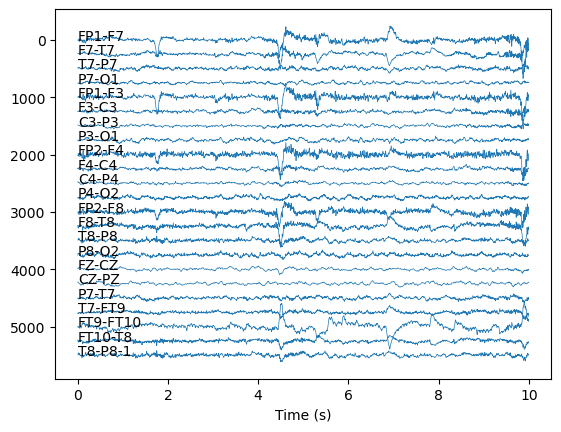

In [3]:
# Load the processed EEG signals and labels
signals = np.load("10sec_signals.npy")
labels = np.load("10sec_labels.npy")

# Create an instance of EdfToNpy (folder and save path not used for plotting)
eeg_plotter = EdfToNpy(folder=[], save_to="")

# Show one random example
eeg_plotter.show_eeg(signals[0])

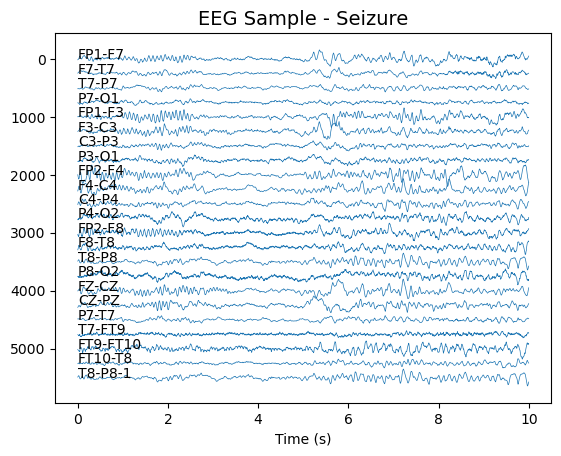

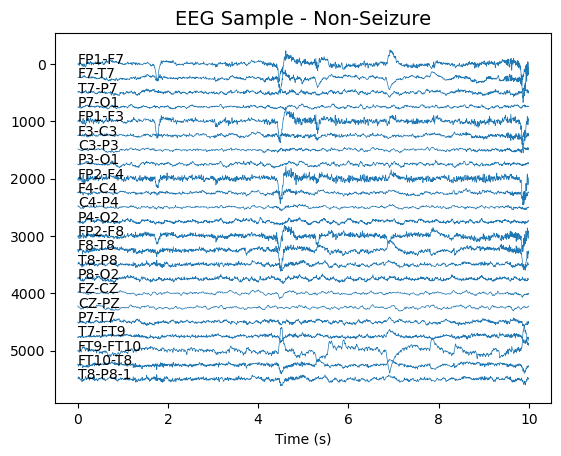

In [4]:
# Show a seizure example
seizure_idx = np.where(labels == 1)[0][0]
eeg_plotter.show_eeg(signals[seizure_idx], label=1)

# Show a non-seizure example
nonseizure_idx = np.where(labels == 0)[0][0]
eeg_plotter.show_eeg(signals[nonseizure_idx], label=0)

#### Bibligraphy

Goton, M. (n.d.). *CHB-MIT EEG Dataset Seizure Detection Demo*. Available at: [https://www.kaggle.com/code/hemangjindal/chb-mit-eeg-dataset-my-notebook#CHB-MIT-eeg-dataset-seizure-detection-demo](https://www.kaggle.com/code/hemangjindal/chb-mit-eeg-dataset-my-notebook#CHB-MIT-eeg-dataset-seizure-detection-demo) [Accessed 20 October 2024].


Shoeb, A. (2009). *CHB-MIT Scalp EEG Database*. Available at: [https://physionet.org/content/chbmit/1.0.0/](https://physionet.org/content/chbmit/1.0.0/) [Accessed 20 October 2024].




#### END